# Installs & Imports
- the tps0822 package needs to be installed each time with '-e' option if you want to be able to change code

In [3]:
# %load_ext autoreload
# %autoreload 1
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from ipywidgets import interact, fixed
import ipywidgets as widget
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder

from drive.MyDrive.Kaggle_TPS_0822 import src

import warnings
warnings.filterwarnings("ignore")

In [8]:
CFG = yaml.load(open('drive/MyDrive/Kaggle_TPS_0822/src/config.YAML', 'rb'))
pd.set_option('display.max_rows', CFG['NROWS'])
pd.set_option('display.max_columns', CFG['NCOLS'])

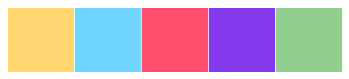

In [ ]:
#Custom Color Palette 🎨
custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Loading Datasets

In [ ]:
train = pd.read_csv(CFG['DATAPATH'] + 'train.csv', index_col='id')
test = pd.read_csv(CFG['DATAPATH'] +'test.csv', index_col='id')
pd.concat([train.head(5), test.head(5)])

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0.0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0.0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0.0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0.0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0.0
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,NaN
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,NaN
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,NaN
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,NaN


In [ ]:
cat_feats = train.select_dtypes('object').columns
int_feats = train.select_dtypes('integer').columns
cont_feats = train.select_dtypes('float').columns

# Basic Statistical Analysis

In [ ]:
@interact(data=fixed(train), dtype=['integer', 'float', 'object'])
def descriptive_info_train(data, dtype):
    dt = data.select_dtypes(dtype).columns
    info = pd.DataFrame({
        'dtype': data[dt].dtypes.tolist(),
        'missing_values': data[dt].isnull().sum().values,
        'unique_values': data[dt].nunique().values}, 
        index = data[dt].columns.values)
    info['missing_value_%'] = (info['missing_values'] / data.shape[0]) * 100
    description = data[dt].describe().T
    return pd.concat([description, info], axis=1)

interactive(children=(Dropdown(description='dtype', options=('integer', 'float', 'object'), value='integer'), …

In [ ]:
@interact(data=fixed(test), dtype=['integer', 'float', 'object'])
def descriptive_info_test(data, dtype):
    dt = data.select_dtypes(dtype).columns
    info = pd.DataFrame({
        'dtype': data[dt].dtypes.tolist(),
        'missing_values': data[dt].isnull().sum().values,
        'unique_values': data[dt].nunique().values}, 
        index = data[dt].columns.values)
    info['missing_value_pct'] = (info['missing_values'] / data.shape[0]) * 100
    description = data[dt].describe().T
    return pd.concat([description, info], axis=1)

interactive(children=(Dropdown(description='dtype', options=('integer', 'float', 'object'), value='integer'), …

- We can label encode 'product_code' in each dataset to transform it into a useful dtype
- The 'attribute' features will pose a problem: they only have a few unique values and they do not fully match up with one another. So, the test set attribute features has values that the train set does not have and vice versa
- The float features in both sets contain missing values, ranging from ~1% to ~8.5%

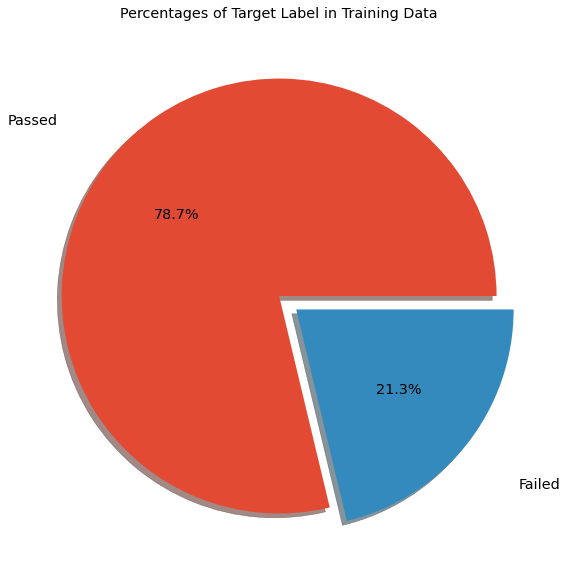

In [ ]:
plt.figure(figsize=(10, 10))

passed, failed = train['failure'].value_counts()

plt.pie(
    [passed, failed], 
    labels=['Passed', 'Failed'], 
    explode=(0, 0.1), 
    shadow=True,
    autopct='%1.1f%%',
    labeldistance=1.3,
    textprops={'fontsize': 'x-large'})
plt.title('Percentages of Target Label in Training Data')
plt.savefig(CFG['IMAGEPATH'] + 'train_target_piechart.png')
plt.show()

- There is a class imbalance in our target feature that we will have to figure out how to deal with.

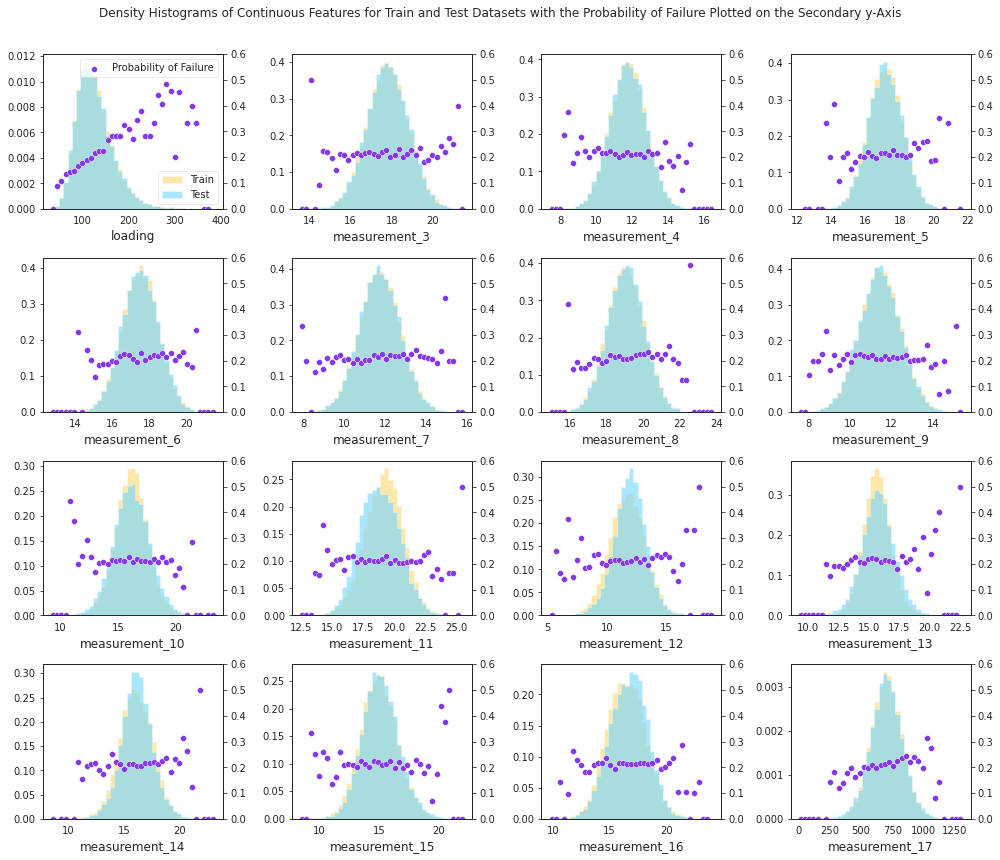

<Figure size 432x288 with 0 Axes>

In [ ]:
def clf_plot_distributions(train_df, test_df, features, ncols=4):
    sns.set_style(style='white')
    nrows = int(len(features) / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, round(nrows*12/ncols)))
    for ax,feature in zip(axes.ravel()[:len(features)],features):
        maximum = max(train[feature].max(), test[feature].max())
        minimum = min(train[feature].min(), test[feature].min())
        bins = np.linspace(minimum, maximum, 40)
        sns.distplot(train[feature], ax=ax, bins=bins, label='Train', hist_kws={'histtype':'stepfilled', 'alpha': 0.6}, kde=False, norm_hist=True)
        sns.distplot(test[feature], ax=ax, bins=bins, label='Test', hist_kws={'histtype':'stepfilled', 'alpha': 0.6}, kde=False, norm_hist=True)
            
        ax2 = ax.twinx()
        total, _ = np.histogram(train[feature], bins=bins)
        fails, _ = np.histogram(train[feature][train['failure'] == 1], bins=bins)
        fail_prob = np.nan_to_num((fails/total), nan=0)
        sns.scatterplot(x=(bins[1:] + bins[:-1])/2, y=fail_prob, label='Probability of Failure', ax=ax2, color=custom_colors[-2])
        ax2.set_ylim(0, 0.6)
        if ax == axes[0, 0]: 
            ax.legend(loc='lower right')
        else:
            leg = ax2.get_legend()
            leg.remove()
        # if ax2 == axes[0, 0]: ax2.legend(loc='upper right')
    for ax in axes.ravel()[len(features):]:
        ax.set_visible(False)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Density Histograms of Continuous Features for Train and Test Datasets with the Probability of Failure Plotted on the Secondary y-Axis')
    plt.show()
    plt.savefig(CFG['IMAGEPATH'] + 'notebooks/images/feature_histograms_with_target_scattered.png')

clf_plot_distributions(train, test, cont_feats)